# Image Classification

Preprocessing -> Feature Extraction -> Training

In [ ]:
from skimage import feature
from imutils import paths
import numpy as np
import argparse
import cv2 as cv
import os
import pandas as pd
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Dataset

In [ ]:
dataset_dir = '/content/drive/My Drive/parkinsons_edit/wave'

trainingPath = os.path.join(dataset_dir, "training")
testingPath = os.path.join(dataset_dir, "testing")

## Metode preprocessing

In [ ]:
def preprocess(image, image_size=128):
		image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) # Ubah mehjadi grayscale
		image = cv.resize(image, (image_size, image_size)) # Resize gambar menjadi suatu ukuran (default = 128)

		image = cv.threshold(image, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1] # Melakukan thresholding dan mengambil hasil gambar thresholding

		return image

# Feature Extraction

In [ ]:
# From: https://www.pyimagesearch.com/2019/04/29/detecting-parkinsons-disease-with-opencv-computer-vision-and-the-spiral-wave-test/
def quantify_image_hog(image): # Histogram of Oriented Gradient features
	features = feature.hog(image, orientations=9, pixels_per_cell=(10, 10), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1")

	return features

In [ ]:
# From: https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/
def quantify_image_lbp(image): # Local Binary Pattern features
  features = feature.local_binary_pattern(image, 24, 8, method="uniform")

  (hist, _) = np.histogram(features.flatten(), bins=np.arange(0, 27), range=(0, 26))

  hist = hist.astype("float")
  hist /= (hist.sum() + 1e-7)

  return hist

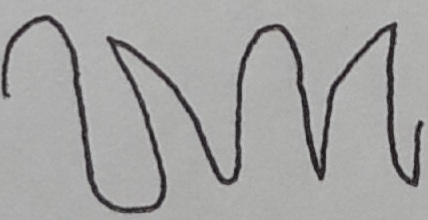

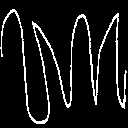

HOG
[0. 0. 0. ... 0. 0. 0.] 4356
LBP
[1.08642578e-02 3.00292969e-02 2.19726562e-03 4.27246094e-04
 1.83105469e-04 1.22070312e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.10156250e-01 4.60205078e-02] 26


In [ ]:
#Testing image

image_test = cv.imread('/content/drive/My Drive/parkinsons_edit/wave/training/parkinson/20200925_124718.jpg')

image_test_preprocessed = preprocess(image_test, image_size=128)

cv2_imshow(image_test)
cv2_imshow(image_test_preprocessed)

features_hog = quantify_image_hog(image_test_preprocessed)
features_lbp = quantify_image_lbp(image_test_preprocessed)

print('HOG')
print(features_hog, len(features_hog))
print('LBP')
print(features_lbp, len(features_lbp))

# Split dataset

In [ ]:
def load_split(path, image_size=200, extraction_method='hog'):
	image_paths = list(paths.list_images(path))
	data = []
	labels = []

	for image_path in image_paths:
		label = image_path.split(os.path.sep)[-2]

		image = cv.imread(image_path)
		image = preprocess(image, image_size=image_size)
		
		if extraction_method == 'hog':
			features = quantify_image_hog(image)
		elif extraction_method == 'lbp':
			features = quantify_image_lbp(image)

		data.append(features)
		labels.append(label)

	return (np.array(data), np.array(labels))

# HOG sz image 128

In [ ]:
resize_128 = 128 # Masing-masing gambar perlu diresize menjadi suatu ukuran yang tetap
extraction_method = 'hog' # 'lbp' atau 'hog'

In [ ]:
(feature_train, label_train) = load_split(trainingPath, image_size=resize_128, extraction_method=extraction_method)
(feature_test, label_test) = load_split(testingPath, image_size=resize_128, extraction_method=extraction_method)

print("Data loaded!")

Data loaded!


## Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
label_train = le.fit_transform(label_train)
label_test = le.transform(label_test)

In [ ]:
label_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
label_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score

## Machine Learning

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(feature_train, label_train)
predictions = logreg.predict(feature_test)

classification_report(label_test, predictions)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(feature_test, label_test))) # .score() -> Accuracy
print("F1", f1_score(label_test, predictions, average="macro"))
print("Precision", precision_score(label_test, predictions, average="macro"))
print("Recall", recall_score(label_test, predictions, average="macro"))

Accuracy of logistic regression classifier on test set: 0.77
F1 0.7664071190211346
Precision 0.7678571428571428
Recall 0.7666666666666666


In [ ]:
from sklearn.svm import LinearSVC

lin_svc = LinearSVC()
lin_svc.get_params()

lin_svc = LinearSVC(penalty='l2', loss='hinge', random_state=10)
lin_svc.fit(feature_train, label_train)
prediksi_lin_svc_test = lin_svc.predict(feature_test)

cm = confusion_matrix(label_test, prediksi_lin_svc_test)
cr = classification_report(label_test, prediksi_lin_svc_test)

print('Accuracy of SVM on test set: {:.2f}'.format(lin_svc.score(feature_test, label_test)))
print('F1 {:.2f}'.format(f1_score(label_test, prediksi_lin_svc_test, average='macro')))
print('Precision{:.2f}'.format(precision_score(label_test, prediksi_lin_svc_test, average='macro')))
print('Recall {:.2f}'.format(recall_score(label_test, prediksi_lin_svc_test, average='macro')))
print()
print(cr)
print(cm)

Accuracy of SVM on test set: 0.83
F1 0.83
Precision0.83
Recall 0.83

              precision    recall  f1-score   support

           0       0.86      0.80      0.83        15
           1       0.81      0.87      0.84        15

    accuracy                           0.83        30
   macro avg       0.83      0.83      0.83        30
weighted avg       0.83      0.83      0.83        30

[[12  3]
 [ 2 13]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=10)
model.fit(feature_train, label_train)

predictions = model.predict(feature_test)

classification_report(label_test, predictions)

print(pd.crosstab(label_test, predictions, rownames=['True'], colnames=['Predicted'], margins=True))

Predicted   0   1  All
True                  
0           8   7   15
1           2  13   15
All        10  20   30


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

print(classification_report(label_test, predictions))

print('Accuracy of Random Forest on test set: {:.2f}'.format(model.score(feature_test, label_test)))
print("F1", f1_score(label_test, predictions, average="macro"))
print("Precision", precision_score(label_test, predictions, average="macro"))
print("Recall", recall_score(label_test, predictions, average="macro"))

              precision    recall  f1-score   support

           0       0.80      0.53      0.64        15
           1       0.65      0.87      0.74        15

    accuracy                           0.70        30
   macro avg       0.73      0.70      0.69        30
weighted avg       0.72      0.70      0.69        30

Accuracy of Random Forest on test set: 0.70
F1 0.6914285714285715
Precision 0.7250000000000001
Recall 0.7


In [ ]:
testingpaths = list(paths.list_images(testingPath))
images = []
for testingpath in testingPaths[:25]:
  image = cv.imread(testingpath)
  output = image.copy()
  output = cv.resize(output, (128, 128))

  image = preprocess(image, image_size=resize_128)

  if extraction_method == 'hog':
    features = quantify_image_hog(image)
  elif extraction_method == 'lbp':
    features = quantify_image_lbp(image)

  preds = model.predict([features])
  label = le.inverse_transform(preds)[0]

  color = (0, 255, 0) if label == 'healthy' else (0, 0, 255)
  cv.putText(output, label, (3, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
  images.append(output)

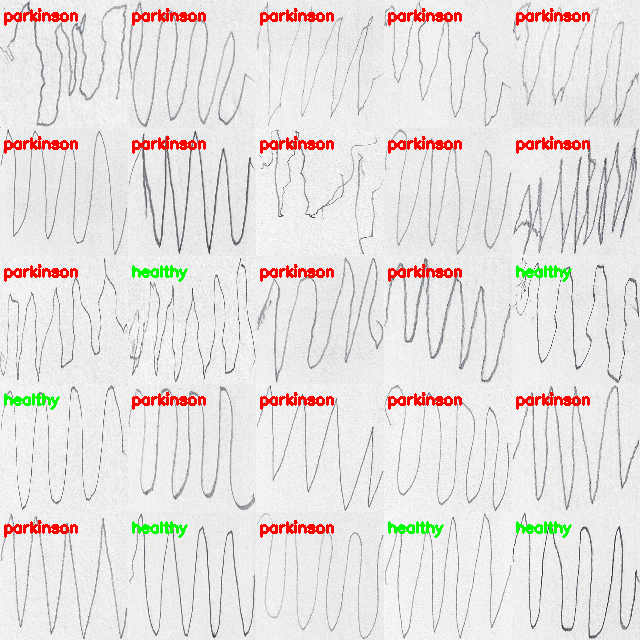

In [ ]:
from imutils import build_montages

montage = build_montages(images, (128, 128), (5, 5))[0]

cv2_imshow(montage)